In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
thrustFromFile = np.genfromtxt('./AeroTech_L1520T.csv',delimiter=',')

In [3]:
thrust = np.insert(thrustFromFile,0,[0,0],axis=0)

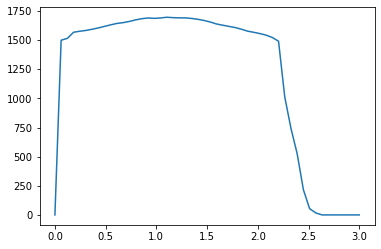

In [4]:
plt.plot(np.linspace(0,3),np.interp(np.linspace(0,3),thrust[:,0],thrust[:,1]));

In [37]:
#returns thrust force given a certain time in Newtons (N)
def thrustFunc(t):
    return np.interp(t,thrust[:,0],thrust[:,1])

#returns an approximation for the density of air at a given altitutde
def rho(altitude):
    rho0 = 1.225 #kg/m^3
    Hn = 10.4*10**3 #meters
    return rho0*np.exp(-altitude/Hn)

In [38]:
dt=0.001
tInitial = 0
tFinal = 60
time = np.arange(tInitial,tFinal,dt)

In [39]:
mass = 20 #kg
gravityForce = np.array([0,0,-9.81])*mass
Area = 0.0232
parachuteDragCoefficient = 10

In [40]:
initialVel = 175
targetAlt = 1100
def velocityProfile(alt):
    return initialVel/np.sqrt(targetAlt)*np.sqrt(targetAlt-alt)

altitudes = np.linspace(0,targetAlt,100)

velocityLookupTableBase = np.array([altitudes,velocityProfile(altitudes)])
velocityLookupTable = np.transpose(np.genfromtxt('./VLT.csv',delimiter=','))

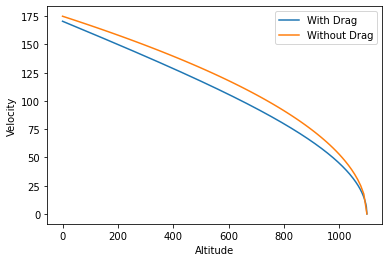

In [41]:
plt.plot(velocityLookupTable[0],velocityLookupTable[1]);
plt.plot(velocityLookupTableBase[0],velocityLookupTableBase[1]);
plt.legend(['With Drag','Without Drag']);
plt.xlabel('Altitude');
plt.ylabel('Velocity');

In [93]:
maxError = 20
controlPeriod = 10 #in number of ticks (if dt = 0.001, then this represents ms)
airbrakesMaxDrag = .2

def errorDecayFunc(alt):
    errorDecayTable = np.array([[targetAlt/2,7/8*targetAlt, 2*targetAlt],
                                [    4      ,    1.5,           .1]])
    #find the index of the first altitude entry which is greater than the current altitude
    index = np.argmax((errorDecayTable[0]-alt)>0)
    return errorDecayTable[1,index]

def calculateError(position,velocity):
    altitude = position[2]
    velocityError = velocity[2] - np.interp(altitude, velocityLookupTable[0],velocityLookupTable[1])
    if(velocityError < 0):
        velocityError = 0
    return velocityError

In [ ]:
positions = np.zeros((len(time),3)); # x,y,z
velocities = np.zeros((len(time),3)); # vx,vy,vz
accelerations = np.zeros((len(time),3)); #ax,ay,az
dragCoefficient  = np.full((len(time)),.4);
#errorArray = np.full((len(time)),0);

integralError = 0;
runControl = True;

for i in range(len(time)-1):
    #determine which way the rocket is pointing
    direction = velocities[i]/(np.linalg.norm(velocities[i])+10**-9)
    
    #if on rail, launch angle is set
    if(positions[i,2]<1):
        direction = np.array([0,np.sin(0.0873),np.cos(0.0873)])
    
    sumForces = gravityForce + (thrustFunc(time[i]) - 1/2*Area*rho(positions[i,2])*np.linalg.norm(velocities[i])**2*dragCoefficient[i])*direction
    
    #ends simulation when rocket hits ground
    if (positions[i,2]<=0) and (time[i]>1):
        break
    
    #deploy parachute when rocket hits apogee
    if ((velocities[i,2]<=0) and (time[i]>1)) and runControl == True:
        runControl = False
        dragCoefficient[i:] = parachuteDragCoefficient
    
    #control algorithim, evaluate periodically (250 ticks or 250 m/s)
    if(i%controlPeriod==0) and runControl:
        #calculate how off the velocity is from desired
        error = calculateError(positions[i],velocities[i])
        
        #clip error so that it is at most maxError
        if error>maxError:
            error = maxError
        
        #add this error to integralError
        #This will take account of continually wrong velocities and give it a boost
        #errorDecay helps this term not just grow over time
        #effectively means it will help velocity get within errorDecay of desiredVelocity
        integralError += error - errorDecayFunc(positions[i,2])
        
        #add setting integralError = 0 if error < 1
        if error<0:
            integralError = 0
        
        if integralError < 0:
            integralError = 0
        
        #calculate how much control we want to exert as a function of the maximum
        control = (error+integralError)/maxError
        
        #if control is greater than 1, bring it down
        if control >1:
            control = 1
        
        #adjust the drag coefficient for the next section of the simulation
        dragCoefficient[i:i+controlPeriod] = dragCoefficient[i:i+controlPeriod]+control*airbrakesMaxDrag
    
    accelerations[i] = sumForces/mass
    velocities[i+1] = accelerations[i]*dt + velocities[i]
    positions[i+1] = velocities[i]*dt + positions[i]

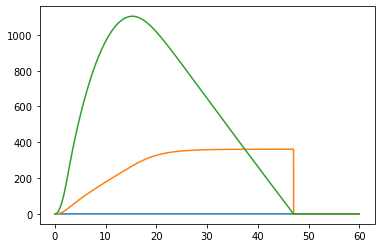

In [86]:
plt.plot(time,positions);

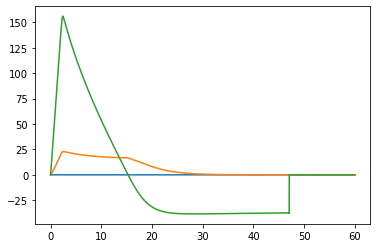

In [87]:
plt.plot(time,velocities);

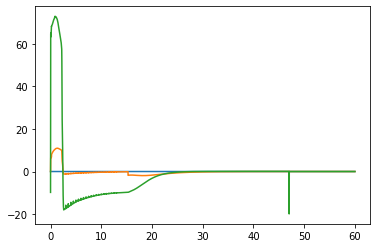

In [88]:
plt.plot(time,accelerations);

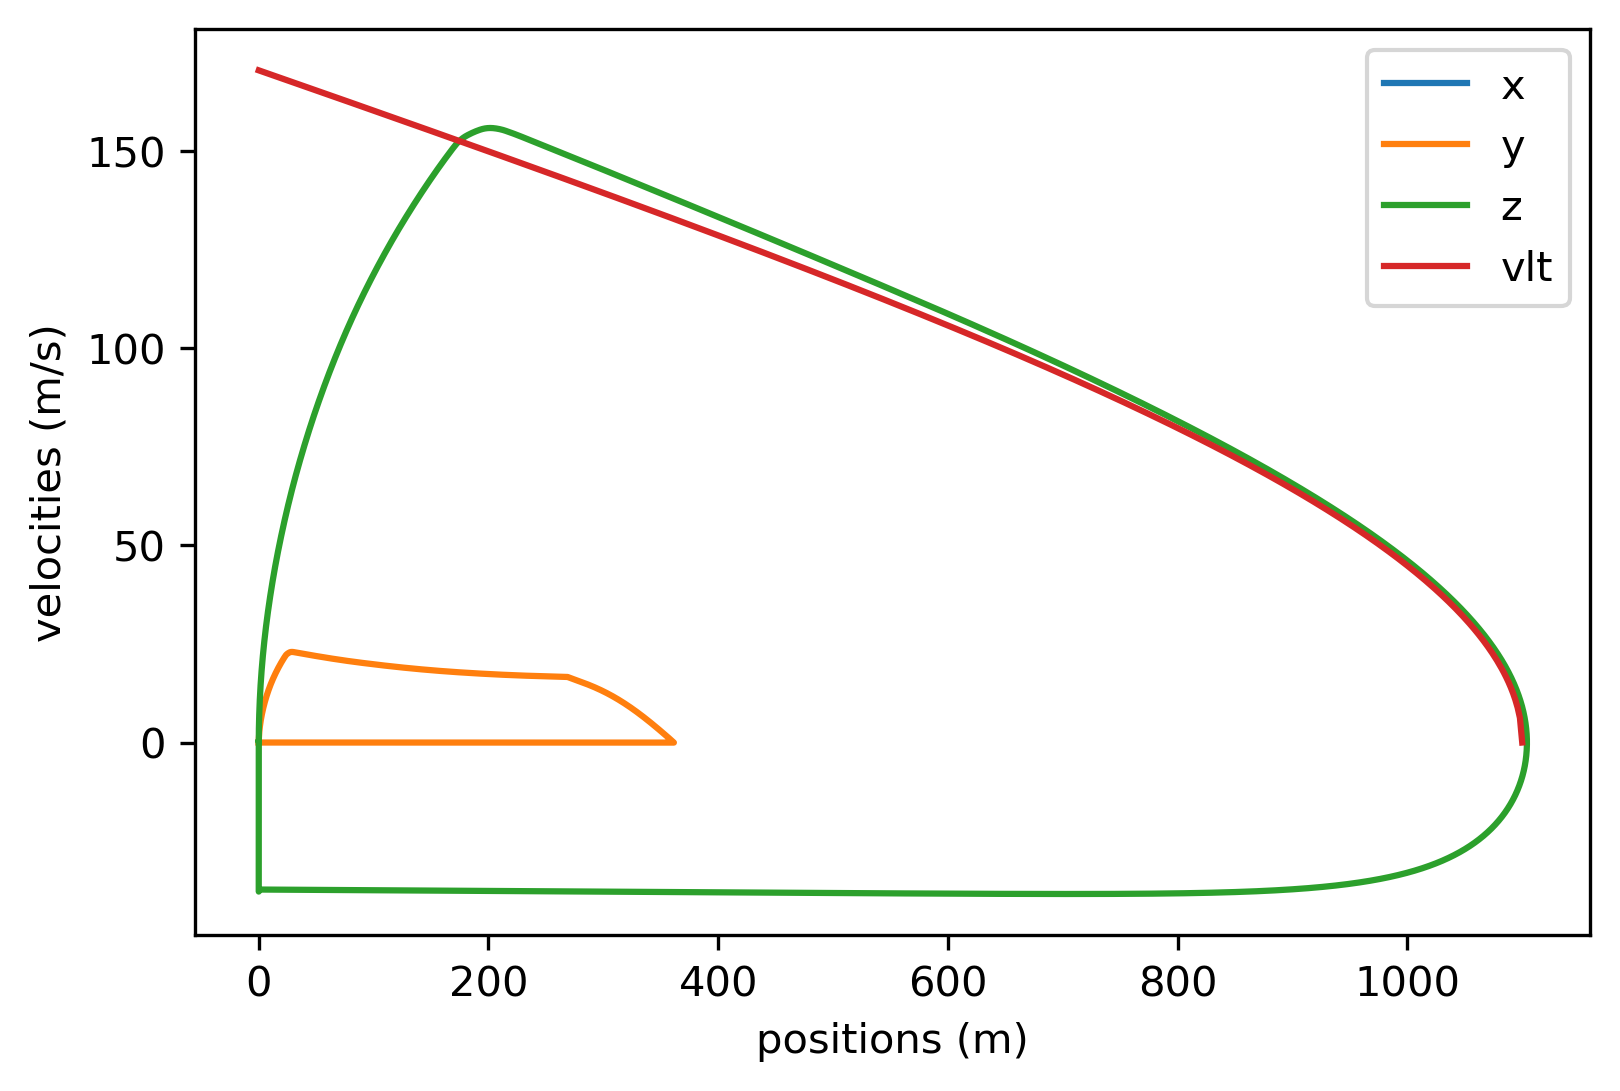

In [89]:
plt.figure(dpi=300)
plt.plot(positions,velocities);
plt.plot(velocityLookupTable[0],velocityLookupTable[1])
plt.xlabel('positions (m)')
plt.ylabel('velocities (m/s)')
plt.legend(['x','y','z','vlt']);

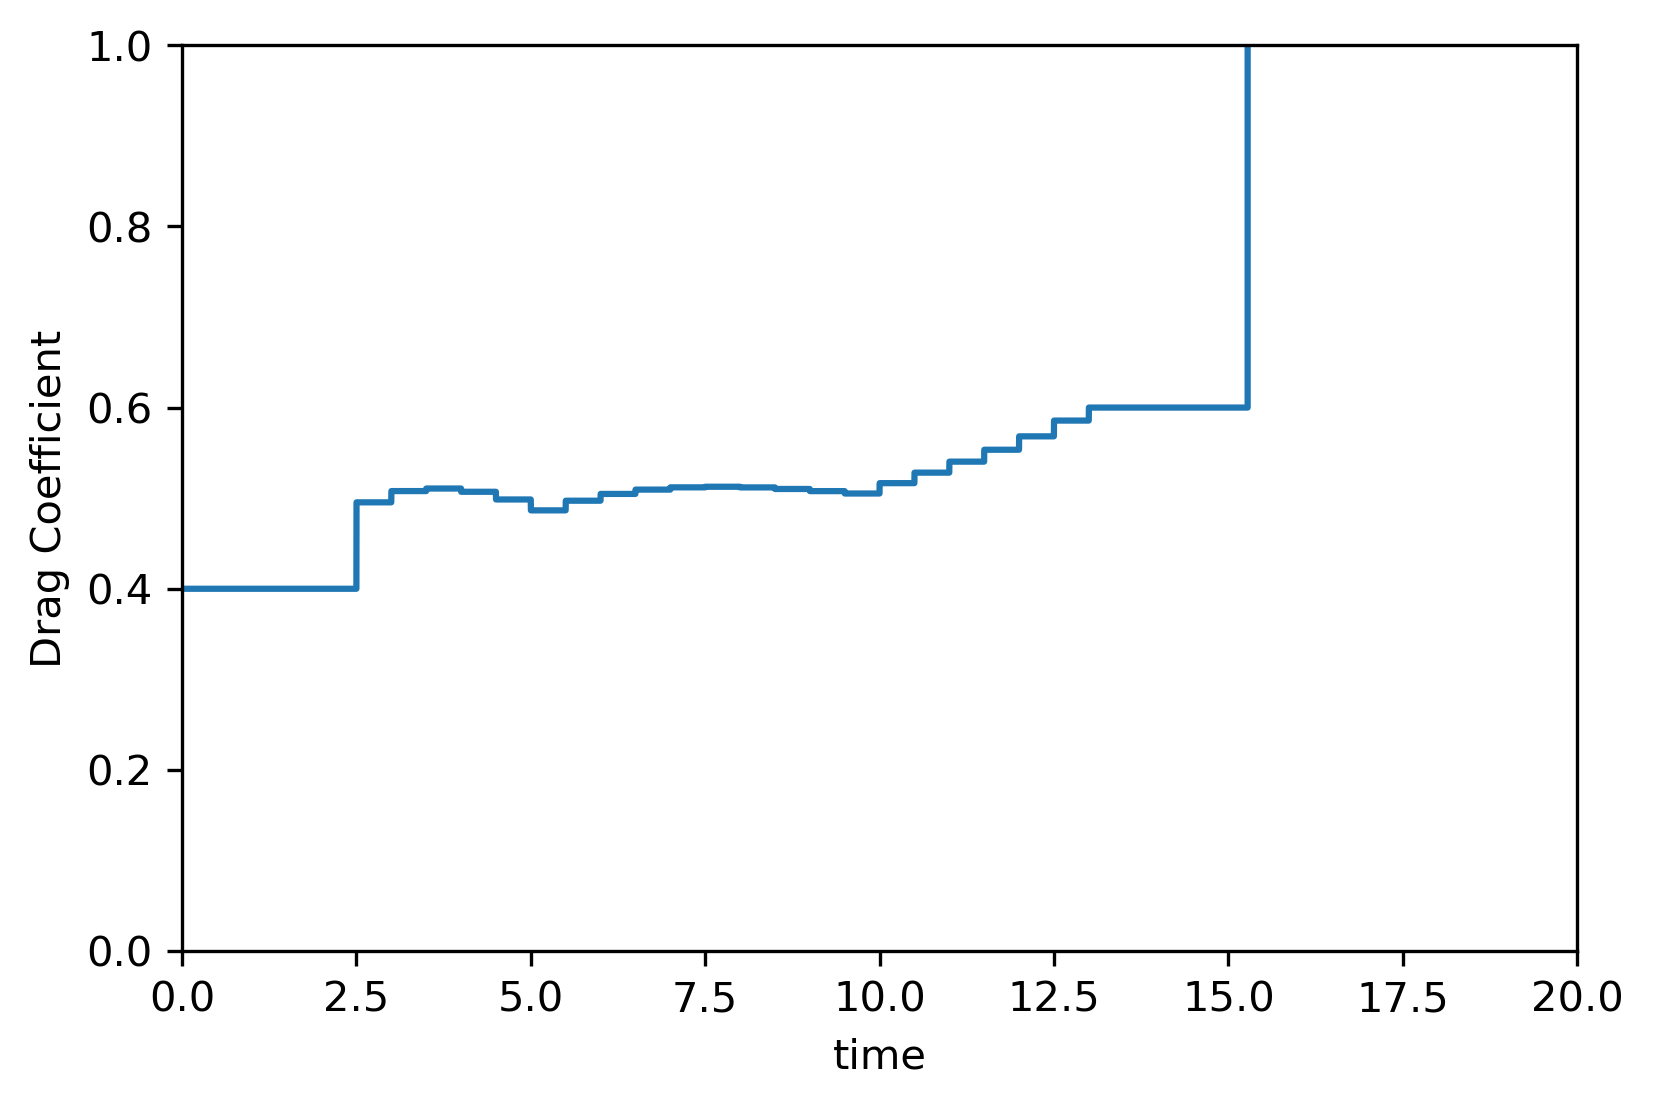

In [90]:
plt.figure(dpi=300)
plt.plot(time,dragCoefficient);
plt.ylim([0,1]);
plt.xlim([0,20]);
plt.xlabel('time')
plt.ylabel('Drag Coefficient');

In [91]:
np.max(positions[:,2])

1104.097745545432

In [92]:
np.max(velocities[:,2])

155.93794396727728